In [1]:

import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
from scipy import optimize
import zipfile
import pandas as pd 

Importing Simulation Data & Defining Variables

In [4]:
zip_file_path = './sim_data/gt_1a_100.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Assume there is only one CSV file in the zip (you might need to modify this if there are multiple CSV files)
    csv_file_name = zip_ref.namelist()[0]

    # Read the CSV file directly from the zip file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)
        


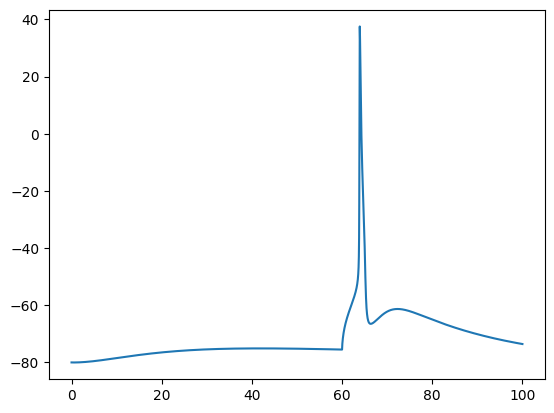

In [5]:
plt.plot(df['time'], df['voltage'], label = 'actual_data')

In [15]:
# Define HH model parameters
#g_Na = 120.0  # Sodium conductance (mS/cm^2), going to recover this
#g_K = 36.0   # Potassium conductance (mS/cm^2)
#g_L = 0.3    # Leak conductance (mS/cm^2)
#E_Na = 50.0  # Sodium reversal potential (mV)
#E_K = -85.0  # Potassium reversal potential (mV)
#E_L = -90  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(params, V, m, h, n, I_params, t):
    g_Na, g_K, g_L, E_Na, E_K, E_L = params
    #I = I_params[0]*np.sin(I_params[1]*t)
    #num = int(t/dt)
    #I = I_params[num]
    I = I_params
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
# dt = 0.01  # Time step (ms)
# t = np.arange(0, 50, dt)  # Time vector (ms)
dt = df['time'][1]-df['time'][0]
print(dt)
dur =(df['time'].to_numpy())[-1]
t = np.arange(0, dur+dt, dt)
#print(dur)
#print(t)

# Initialize state variables
#print(V0)
V0 = df['voltage'][0]  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

I_data = df['stim'].to_numpy()
V_data = df['voltage'].to_numpy()

0.0125


In [16]:
len(I_data)
len(V_data)

8001

In [5]:
def integrate_HH(params, V0, m, h, n, I_params, dt, t):
    g_Na, g_K, g_L, E_Na, E_K, E_L = params
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(params, V, m, h, n, I_params[i], t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record


    

In [29]:
#ADJOINT

# import zipfile
# import csv

# with zipfile.ZipFile('./sim_data/gt_multa.zip', 'r') as zip_ref:
#     zip_ref.extractall()
    
# with open('gt_multa.csv', newline='') as csvfile:
#     data = list(csv.reader(csvfile))
# #     
# data_steps = [row[0] for row in data][1:-1] # extract time data
# data_steps = np.array([float(i) for i in data_steps]) # convert to numpy array of floats

# V_data = [row[1] for row in data][1:-1]
# V_data = np.array([float(i) for i in V_data])

# I_data = [row[2] for row in data][1:-1]
# I_data = np.array([float(i) for i in I_data])

# len(V_data)
# len(I_data)

In [30]:
# plt.plot(data_steps, V_data, label = 'V')
# plt.plot(data_steps, I_data, label = 'I')
# plt.xlabel('time')
# # plt.legend()

In [31]:
len(I_data)
len(t)

8001

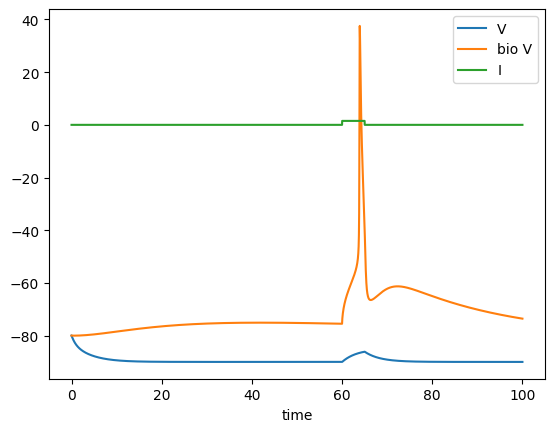

In [32]:
#Fake data

A = 4.5
w = 0.
params = [120.0, 36.0, 0.3, 50.0, -85.0, -90.0]
#I_params = np.array([A, w])
I_stimulus = I_data

V_record = integrate_HH(params, V0, m, h, n, I_stimulus, dt, t)

#I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, V_data, label = 'bio V')
plt.plot(t, I_data, label = 'I')
plt.xlabel('time')
plt.legend()

In [33]:
V_subsamp = V_record #[::10]
    
mean = np.mean(V_record)
stddev = np.std(V_record)

#noise = np.random.normal(0, stddev, len(V_subsamp))
#noise = np.random.normal(0,1,len(V_subsamp))
noise = 0
V_data_sim = V_subsamp + noise

data_steps = t #[::10]


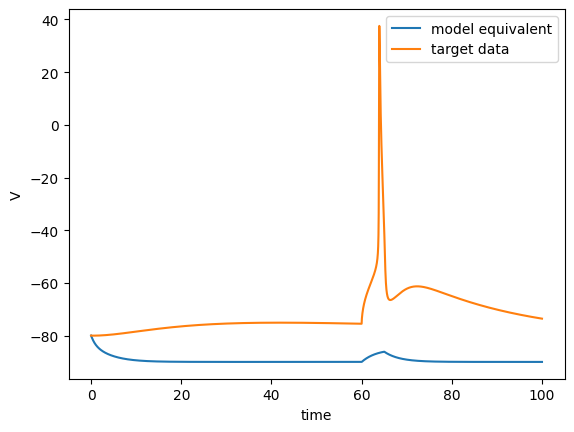

In [34]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(t, V_data, label = 'target data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

In [35]:
#cost function

In [19]:
def forward_model_cost(params, I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # run forward step
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(params,V, m, h, n, I_params[i], t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute cost
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2 # [elu(V_record) - elu(V_data)]**2
            
    # cost += l2norm(I)        
    cost = cost/len(t)

            
    #return V_record, cost
    return cost

# look at total cost before any optimization

# first guess

params = [120.0, 36.0, 0.3, 50.0, -85.0, -90.0]

total_cost = forward_model_cost(params, I_data, V0, m, h, n, dt, t, data_steps, V_data)
total_cost       

array([692.89264308])

In [38]:
# test autograd with I_params used to create fake data

grad_AD(params, I_stimulus, V0, m, h, n, dt, t, data_steps, V_data)

([array(-0.00032331),
  array(-0.01191342),
  array(68.87606028),
  array(-0.00028601),
  array(-0.43100768),
  array(-35.14788706)],)

In [141]:
# #fd check 

# #g_Na1 = np.random.uniform(90, 170)
# C_m1 = np.random.uniform(0, 1)
# #L1 = forward_model_cost(g_Na1, C_m1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
# L1 = forward_model_cost(g_Na1, I_data, V0, m, h, n, dt, t, data_steps, V_data)

# p = np.random.randint(0,5000)
# s = 1e-4 # step size
# g_Na2 = g_Na1 + s*p
# #C_m2 = C_m1 + s*p
# #L2 = forward_model_cost(g_Na2, C_m2, I_data, V0, m, h, n, dt, t, data_steps, V_data)
# L2 = forward_model_cost(g_Na2, I_data, V0, m, h, n, dt, t, data_steps, V_data)
# dL_dV_p_diff = (L2 - L1) / s

# #g = grad_AD(g_Na1, C_m1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
# g = grad_AD(g_Na1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
# dL_dV_p = np.dot(g, p)

# grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# print('step size=', s, ', gradient finite difference error=', grad_err)

step size= 0.0001 , gradient finite difference error= [2.3282285e-07]


step size= 1.0 , example gradient finite difference error= [0.00240625]
step size= 0.1 , example gradient finite difference error= [0.00023228]
step size= 0.01 , example gradient finite difference error= [2.31462716e-05]
step size= 0.001 , example gradient finite difference error= [2.30608683e-06]
step size= 0.0001 , example gradient finite difference error= [2.31150619e-07]
step size= 1e-05 , example gradient finite difference error= [1.35018276e-07]
step size= 1e-06 , example gradient finite difference error= [6.49219945e-07]
step size= 1e-07 , example gradient finite difference error= [3.17902904e-06]
step size= 1e-08 , example gradient finite difference error= [0.00020675]
step size= 1e-09 , example gradient finite difference error= [0.00681343]
step size= 1e-10 , example gradient finite difference error= [0.01669588]
step size= 1e-11 , example gradient finite difference error= [0.06834664]
step size= 1e-12 , example gradient finite difference error= [0.31762752]
step size= 1e-13 ,

Text(0, 0.5, 'error')

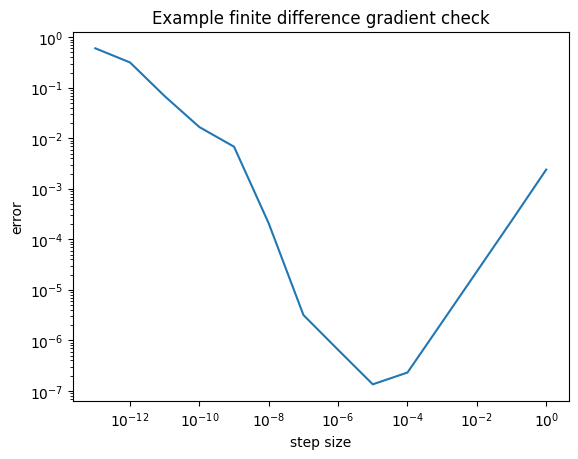

In [142]:
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

g_Na1 = np.random.uniform(90, 170)
#C_m1 = np.random.uniform(0, 1)
#L1 = forward_model_cost(g_Na1, C_m1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
L1 = forward_model_cost(g_Na1, I_data, V0, m, h, n, dt, t, data_steps, V_data)

# compute gradient using autograd
g = grad_AD(g_Na1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
#g = grad_AD(g_Na1, C_m1, I_data, V0, m, h, n, dt, t, data_steps, V_data)
dL_dV_p = np.dot(g, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    g_Na2 = g_Na1 + s*p
    #C_m2 = C_m1 + s*p
    #L2 = forward_model_cost(g_Na2, C_m2, I_data, V0, m, h, n, dt, t, data_steps, V_data)
    L2 = forward_model_cost(g_Na2, I_data, V0, m, h, n, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

In [50]:
#initial_guess = 125.0
initial_guess = [160.0, 36.0, 0.3, 50.0, -75.0, -80.0]
bnds = [(2, 180), (10, 40), (0.1, 0.5), (30, 100), (-100, -50), (-120, -50)]

def callback(x):
    error = forward_model_cost(x, I_data, V0, m, h, n, dt, t, data_steps, V_data)
    print(f"Iteration: {callback.iteration}, x: {x}, Cost: {error}")
    callback.iteration += 1
   
callback.iteration = 0

optim = optimize.minimize(forward_model_cost, initial_guess, args = (I_data, V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, bounds = bnds, method =  'Nelder-Mead', callback=callback, tol = 1e-5) #'slsqp' ) 'BFGS')

#optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  #jac = grad_AD, method = 'Nelder-Mead')#'BFGS')

#def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data, g_Na):

optim

Iteration: 0, x: [164.      36.9      0.3075  51.25   -76.875  -72.    ], Cost: [84.87449043]
Iteration: 1, x: [164.      36.9      0.3075  51.25   -76.875  -72.    ], Cost: [84.87449043]
Iteration: 2, x: [164.      36.9      0.3075  51.25   -76.875  -72.    ], Cost: [84.87449043]
Iteration: 3, x: [164.      36.9      0.3075  51.25   -76.875  -72.    ], Cost: [84.87449043]
Iteration: 4, x: [164.      36.9      0.3075  51.25   -76.875  -72.    ], Cost: [84.87449043]
Iteration: 5, x: [161.97530864  38.84444444   0.30296296  52.12962963 -74.01234568
 -71.57201646], Cost: [83.83554924]
Iteration: 6, x: [161.97530864  38.84444444   0.30296296  52.12962963 -74.01234568
 -71.57201646], Cost: [83.83554924]
Iteration: 7, x: [161.97530864  38.84444444   0.30296296  52.12962963 -74.01234568
 -71.57201646], Cost: [83.83554924]
Iteration: 8, x: [161.97530864  38.84444444   0.30296296  52.12962963 -74.01234568
 -71.57201646], Cost: [83.83554924]
Iteration: 9, x: [161.97530864  38.84444444   0.302962

Iteration: 70, x: [178.85815435  39.75968489   0.24763837  53.34214436 -65.68307114
 -73.99472329], Cost: [79.74836013]
Iteration: 71, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 72, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 73, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 74, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 75, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 76, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 77, x: [177.91341691  39.80493185   0.24167695  53.28402016 -64.95758165
 -74.65950924], Cost: [79.21350639]
Iteration: 78, x: [177.91341691  39.8049

Iteration: 139, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 140, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 141, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 142, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 143, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 144, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 145, x: [180.          39.33094448   0.20641589  52.17902062 -65.98575603
 -74.8761576 ], Cost: [75.80475519]
Iteration: 146, x: [180.          39.30440703   0.20523948  52.16136638 -65.99814509
 -74.89614101], Cost: [75.73477773]
Iteration: 147, x: [180.        

Iteration: 201, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 202, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 203, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 204, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 205, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 206, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 207, x: [ 1.80000000e+02  3.86149059e+01  1.34603904e-01  5.00000000e+01
 -6.92073871e+01 -7.46054686e+01], Cost: [69.78001714]
Iteration: 208, x: [ 1.8000

Iteration: 260, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 261, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 262, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 263, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 264, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 265, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 266, x: [ 1.79999738e+02  3.82838247e+01  1.06383080e-01  5.00008764e+01
 -7.08081389e+01 -7.42464268e+01], Cost: [67.8865064]
Iteration: 267, x: [ 1.79999738e+0

Iteration: 320, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 321, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 322, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 323, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 324, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 325, x: [ 1.79999657e+02  3.82204564e+01  1.00050639e-01  5.00000342e+01
 -7.11506005e+01 -7.41809925e+01], Cost: [67.48208492]
Iteration: 326, x: [ 1.79999662e+02  3.82199326e+01  1.00015824e-01  5.00001852e+01
 -7.11526066e+01 -7.41804939e+01], Cost: [67.47960519]
Iteration: 327, x: [ 1.7999

Iteration: 379, x: [ 1.79999660e+02  3.82197532e+01  1.00000127e-01  5.00001696e+01
 -7.11534669e+01 -7.41803199e+01], Cost: [67.47856334]
Iteration: 380, x: [ 1.79999660e+02  3.82197532e+01  1.00000127e-01  5.00001696e+01
 -7.11534669e+01 -7.41803199e+01], Cost: [67.47856334]
Iteration: 381, x: [ 1.79999660e+02  3.82197532e+01  1.00000127e-01  5.00001696e+01
 -7.11534669e+01 -7.41803199e+01], Cost: [67.47856334]
Iteration: 382, x: [ 1.79999660e+02  3.82197532e+01  1.00000127e-01  5.00001696e+01
 -7.11534669e+01 -7.41803199e+01], Cost: [67.47856334]
Iteration: 383, x: [ 1.79999660e+02  3.82197485e+01  1.00000103e-01  5.00001692e+01
 -7.11534714e+01 -7.41803163e+01], Cost: [67.4785623]
Iteration: 384, x: [ 1.79999660e+02  3.82197485e+01  1.00000103e-01  5.00001692e+01
 -7.11534714e+01 -7.41803163e+01], Cost: [67.4785623]
Iteration: 385, x: [ 1.79999660e+02  3.82197485e+01  1.00000103e-01  5.00001692e+01
 -7.11534714e+01 -7.41803163e+01], Cost: [67.4785623]
Iteration: 386, x: [ 1.7999966

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 67.47855538633736
             x: [ 1.800e+02  3.822e+01  1.000e-01  5.000e+01 -7.115e+01
                 -7.418e+01]
           nit: 399
          nfev: 685
 final_simplex: (array([[ 1.800e+02,  3.822e+01, ..., -7.115e+01,
                        -7.418e+01],
                       [ 1.800e+02,  3.822e+01, ..., -7.115e+01,
                        -7.418e+01],
                       ...,
                       [ 1.800e+02,  3.822e+01, ..., -7.115e+01,
                        -7.418e+01],
                       [ 1.800e+02,  3.822e+01, ..., -7.115e+01,
                        -7.418e+01]]), array([ 6.748e+01,  6.748e+01,  6.748e+01,  6.748e+01,
                        6.748e+01,  6.748e+01,  6.748e+01]))

In [51]:
optim.x

array([ 1.79999660e+02,  3.82197500e+01,  1.00000004e-01,  5.00001706e+01,
       -7.11534749e+01, -7.41803175e+01])

In [52]:
optim.x.tolist()

[179.99966016567535,
 38.219750042865556,
 0.1000000043678328,
 50.00017061788125,
 -71.1534748944077,
 -74.18031754542042]

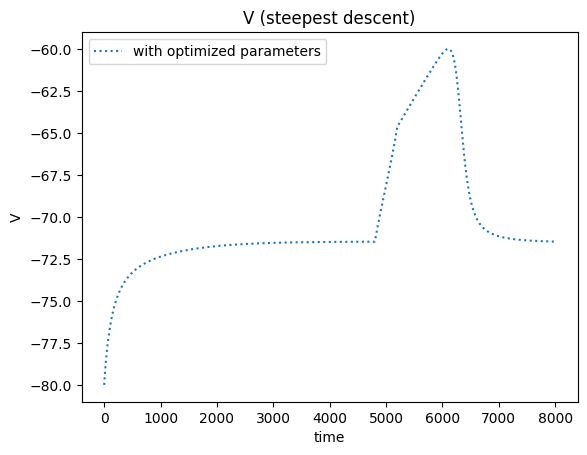

In [54]:
V_final = integrate_HH(optim.x, V0, m, h, n, I_stimulus, dt, t)

plt.figure()
plt.plot(V_final, ls = 'dotted', label = 'with optimized parameters')
#plt.plot(V_data, label = 'original')
#plt.plot(t, V_data, label = 'original')
plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

In [ ]:
# def parameter_recovery(parameters, v_array, time, I_known):
#     C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = parameters
    
#     # Define the HH model equations
#     def alpha_m(V):
#         return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

#     def beta_m(V):
#         return 4.0 * np.exp(-(V + 65.0) / 18.0)

#     def alpha_h(V):
#         return 0.07 * np.exp(-(V + 65.0) / 20.0)

#     def beta_h(V):
#         return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

#     def alpha_n(V):
#         return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

#     def beta_n(V):
#         return 0.125 * np.exp(-(V + 65) / 80.0)

#     def model(y, time, I, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L):
#         V, m, h, n = y
    
#         dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
#         dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
#         dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
#         dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    
#         return [dVdt, dmdt, dhdt, dndt]
    
#     def adj_model(y_adj, time, C_m, g_Na, g_K, g_L, E_Na, E_L, I_known, v_array):
#         lambda_V, lambda_m, lambda_h, lambda_n = y_adj
        
#         # Extract state variables
#         V, m, h, n = odeint(model, initial_conditions, time, args=(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_known)).T

#         # Sensitivity equations (adjoint model)
#         dVdt_adj = -lambda_V + g_Na * m**3 * h * lambda_V + g_K * n**4 * lambda_V + g_L * lambda_V
#         dmdt_adj = -alpha_m(V) * (1 - m) * lambda_m + beta_m(V) * m * lambda_m
#         dhdt_adj = -alpha_h(V) * (1 - h) * lambda_h + beta_h(V) * h * lambda_h
#         dndt_adj = -alpha_n(V) * (1 - n) * lambda_n + beta_n(V) * n * lambda_n

#         return [dVdt_adj, dmdt_adj, dhdt_adj, dndt_adj]
    
#     def objective_fnct(parameters, time, v_array, I_known): 
#         C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = parameters
    
#         # Simulate the Hodgkin-Huxley model using the given parameters
#         V, m, h, n = odeint(model, initial_conditions, time, args=(parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], lambda time: I_known)).T

#         # Initial conditions for adjoint model
#         initial_conditions_adj = [0, 0, 0, 0]

#         # Simulate the adjoint model
#         lambda_V, lambda_m, lambda_h, lambda_n = odeint(adjoint_model, initial_conditions_adj, t[::-1], args=(parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], lambda time: I_known, v_array[::-1])).T

#         # Calculate the mean squared difference between simulated and observed membrane potential
#         mse = np.mean((v_array - V)**2)

#         return mse
    
#     # Set the initial conditions for the state vector [V, m, h, n]
#     initial_conditions = [-65, 0.05, 0.6, 0.32]
    
#     bounds = [(1e-6, 1), (1e-6, 100), (1e-6, 100), (1e-6, 10), (-100, 100), (-100, 100), (-100, 100)]

#     # Perform the optimization using the adjoint method with bounds
#     result = minimize(objective_fnct, parameters, args=(time, v_array, i_array), bounds=bounds)

#     # Extract the optimized parameters
#     optimized_parameters = result.x

#     return optimized_parameters


In [ ]:
# initial_guess_parameters = [1, 50, 20, 0.5, 50, -77, -54.387]
# v_array = (df['voltage'].to_numpy())
# i_array = (df['voltage'].to_numpy())
# dt = df['time'][1]-df['time'][0]
# dur =(df['time'].to_numpy())[-1]
#time = np.arange(0, dur, dt)
# type(i_array)

In [ ]:

# Recover parameters using the adjoint method
# optimized_parameters = parameter_recovery(initial_guess_parameters, v_array, time, i_array)

# print("Optimized Parameters:", optimized_parameters)


Suppose I wanted to run this on HH simulated data, and not morphologically generated data:

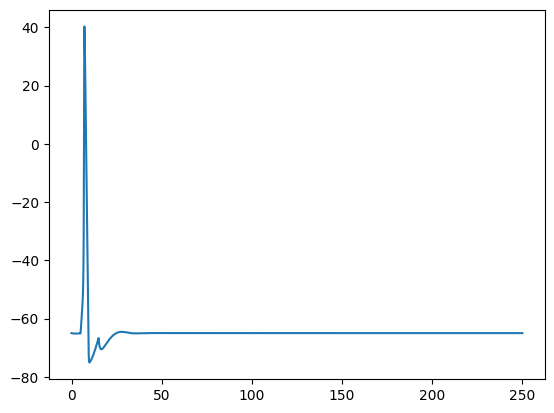

In [3]:
zip_file_path = './sim_data/hh_1ap.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Assume there is only one CSV file in the zip (you might need to modify this if there are multiple CSV files)
    csv_file_name = zip_ref.namelist()[0]

    # Read the CSV file directly from the zip file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

plt.plot(df['time'], df['voltage'], label = 'actual_data')

In [4]:
# Define HH model parameters
#g_Na = 120.0  # Sodium conductance (mS/cm^2), going to recover this
#g_K = 36.0   # Potassium conductance (mS/cm^2)
#g_L = 0.3    # Leak conductance (mS/cm^2)
#E_Na = 50.0  # Sodium reversal potential (mV)
#E_K = -85.0  # Potassium reversal potential (mV)
#E_L = -90  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(params, V, m, h, n, I_params, t):
    g_Na, g_K, g_L, E_Na, E_K, E_L = params
    #I = I_params[0]*np.sin(I_params[1]*t)
    #num = int(t/dt)
    #I = I_params[num]
    I = I_params
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
# dt = 0.01  # Time step (ms)
# t = np.arange(0, 50, dt)  # Time vector (ms)
dt = df['time'][1]-df['time'][0]
print(dt)
dur =(df['time'].to_numpy())[-1]
t = np.arange(0, dur+dt, dt)
#print(dur)
#print(t)

# Initialize state variables
#print(V0)
V0 = df['voltage'][0]  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

I_data = df['stim'].to_numpy()
V_data = df['voltage'].to_numpy()

0.025


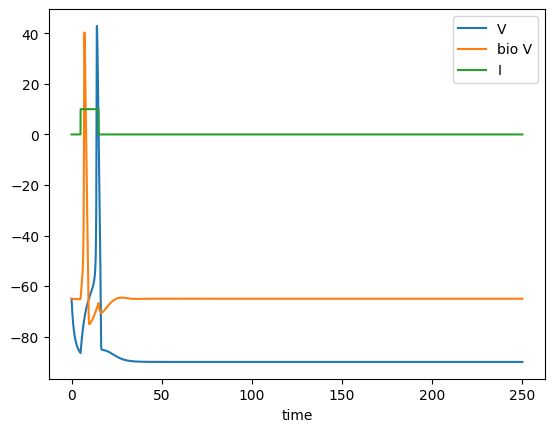

In [6]:
#Fake data

A = 4.5
w = 0.
params = [120.0, 36.0, 0.3, 50.0, -85.0, -90.0]
#I_params = np.array([A, w])
I_stimulus = I_data

V_record = integrate_HH(params, V0, m, h, n, I_stimulus, dt, t)

#I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, V_data, label = 'bio V')
plt.plot(t, I_data, label = 'I')
plt.xlabel('time')
plt.legend()

In [9]:

params = [120.0, 36.0, 0.3, 50.0, -85.0, -90.0]
data_steps = t #[::10]
total_cost = forward_model_cost(params, I_data, V0, m, h, n, dt, t, data_steps, V_data)
total_cost  

array([692.89264308])

In [10]:
grad_AD = grad(forward_model_cost, [0]) 

In [11]:
grad_AD(params, I_stimulus, V0, m, h, n, dt, t, data_steps, V_data)

([array(0.52274003),
  array(-1.41162104),
  array(-303.67892014),
  array(1.0350101),
  array(-0.74871274),
  array(-42.71286879)],)

In [14]:
#initial_guess = 125.0
initial_guess = [123.0, 36.0, 0.4, 52.0, -72.0, -54.0]
bnds = [(2, 180), (10, 40), (0.1, 0.5), (30, 100), (-100, -50), (-120, -50)]

def callback(x):
    error = forward_model_cost(x, I_data, V0, m, h, n, dt, t, data_steps, V_data)
    #print(f"Iteration: {callback.iteration}, x: {x}, Cost: {error}")
    callback.iteration += 1
   
callback.iteration = 0

optim = optimize.minimize(forward_model_cost, initial_guess, args = (I_data, V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, bounds = bnds, method =  'Nelder-Mead', callback=callback, tol = 1e-5) #'slsqp' ) 'BFGS')

#optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  #jac = grad_AD, method = 'Nelder-Mead')#'BFGS')

#def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data, g_Na):

optim

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0013907243606341541
             x: [ 1.308e+02  3.803e+01  3.002e-01  4.894e+01 -7.674e+01
                 -5.423e+01]
           nit: 431
          nfev: 697
 final_simplex: (array([[ 1.308e+02,  3.803e+01, ..., -7.674e+01,
                        -5.423e+01],
                       [ 1.308e+02,  3.803e+01, ..., -7.674e+01,
                        -5.423e+01],
                       ...,
                       [ 1.308e+02,  3.803e+01, ..., -7.674e+01,
                        -5.423e+01],
                       [ 1.308e+02,  3.803e+01, ..., -7.674e+01,
                        -5.423e+01]]), array([ 1.391e-03,  1.391e-03,  1.391e-03,  1.391e-03,
                        1.391e-03,  1.391e-03,  1.391e-03]))

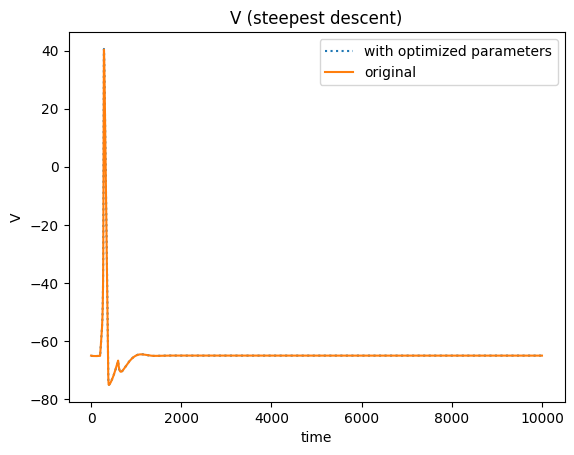

In [16]:
V_final = integrate_HH(optim.x, V0, m, h, n, I_stimulus, dt, t)

plt.figure()
plt.plot(V_final, ls = 'dotted', label = 'with optimized parameters')
plt.plot(V_data, label = 'original')
#plt.plot(t, V_data, label = 'original')
plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()